<a href="https://colab.research.google.com/github/cristianbalea/ml-project/blob/main/proiect_balea_ciobanica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock, Paper, Scissors image classification

## Downloading the dataset from Kaggle

In [ ]:
! pip install fastai
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d drgfreeman/rockpaperscissors

! unzip rockpaperscissors.zip

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os 
import fastai

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from keras.optimizers import RMSprop
from keras.preprocessing import image
from fastai.vision.all import *
from pathlib import Path
import PIL
import PIL.Image

## Organizing dataset

In [2]:
build_dir = '/content/rps-cv-images'

rock_dir = os.path.join(build_dir, 'rock')
paper_dir = os.path.join(build_dir, 'paper')
scissors_dir = os.path.join(build_dir, 'scissors')

os.listdir(build_dir)

['scissors', 'paper', 'README_rpc-cv-images.txt', 'rock']

In [3]:
print('paper: ', len(os.listdir(paper_dir)))
print('scissors: ', len(os.listdir(scissors_dir)))
print('rock: ', len(os.listdir(rock_dir)))

paper:  712
scissors:  750
rock:  726


## Explore the dataset

In [4]:
visualisation_dir = Path('../content/rps-cv-images')
print(visualisation_dir)


../content/rps-cv-images


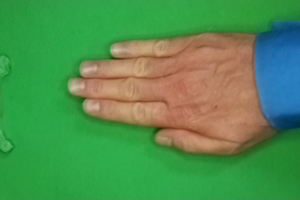

In [5]:
#Images example
papers = list(visualisation_dir.glob('paper/*'))
rocks = list(visualisation_dir.glob('rock/*'))
scissors = list(visualisation_dir.glob('scissors/*'))
Image.open(str(papers[10]))


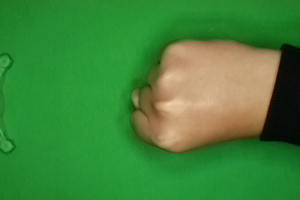

In [6]:
Image.open(str(rocks[1]))

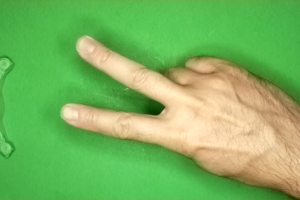

In [7]:
Image.open(str(scissors[45]))

## Data preprocessing

### Data Augmentation

In [8]:
# Create an image data generator with specified transformations and preprocessing
generator = ImageDataGenerator(
    validation_split=0.2,  # Split the data into 80% training and 20% validation
    rescale=1/255,  # Rescale pixel values to range between 0 and 1
    shear_range=0.2,  # Randomly apply shearing transformations
    zoom_range=0.2,  # Randomly apply zooming transformations
    rotation_range=90,  # Randomly rotate the images within the range of -20 to 20 degrees
    fill_mode='nearest'  # Fill in any newly created pixels using the nearest pixel value
)

# Create a directory iterator for training data
train_data = generator.flow_from_directory(
    build_dir,  # Path to the directory containing the training and validation data
    batch_size=32,  # Number of images to load and process at each iteration
    target_size=(150,150),  # Resize input images to the specified dimensions
    subset='training'  # Retrieve images from the training subset of the directory
)

# Create a directory iterator for validation data
val_data = generator.flow_from_directory(
    build_dir,  # Path to the directory containing the training and validation data
    batch_size=32,  # Number of images to load and process at each iteration
    target_size=(150,150),  # Resize input images to the specified dimensions
    subset='validation'  # Retrieve images from the validation subset of the directory
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


### Visualize the augmented data

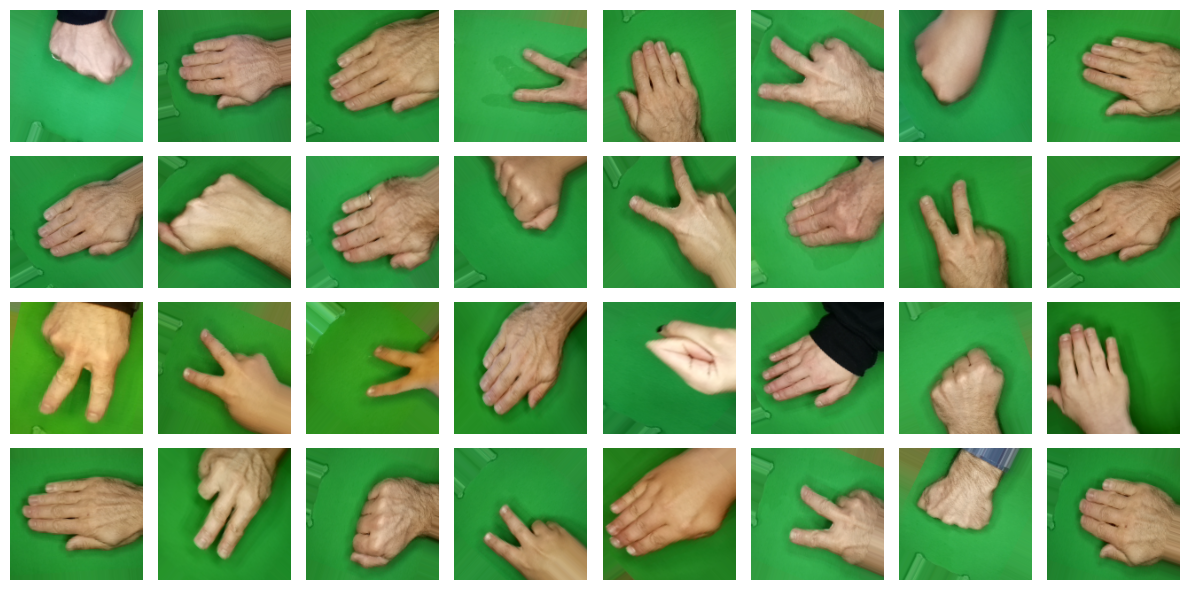

In [9]:
# Retrieve a batch of augmented images from the data generator
augmented_images = next(train_data)

# Display the augmented images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    image = augmented_images[0][i]
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Create a model

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    # Convolutional layer with 32 filters, each of size 3x3.
    # ReLU activation function is applied to introduce non-linearity.
    # The input shape of the layer is (150, 150, 3), representing RGB images.

    tf.keras.layers.MaxPooling2D(2, 2),
    # Max pooling layer with a pool size of 2x2.
    # It reduces the spatial dimensions of the previous layer output by taking the maximum value in each pooling region.

    tf.keras.layers.Dropout(0.2),
    # Dropout layer with a rate of 0.2.
    # It randomly drops 20% of the input units during training to reduce overfitting.

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # Convolutional layer with 64 filters of size 3x3.
    # ReLU activation function is applied to introduce non-linearity.

    tf.keras.layers.MaxPooling2D(2,2),
    # Max pooling layer with a pool size of 2x2.

    tf.keras.layers.Dropout(0.2),
    # Dropout layer with a rate of 0.2.

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # Convolutional layer with 128 filters of size 3x3.
    # ReLU activation function is applied to introduce non-linearity.

    tf.keras.layers.MaxPooling2D(2,2),
    # Max pooling layer with a pool size of 2x2.

    tf.keras.layers.Dropout(0.2),
    # Dropout layer with a rate of 0.2.

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # Convolutional layer with 128 filters of size 3x3.
    # ReLU activation function is applied to introduce non-linearity.

    tf.keras.layers.MaxPooling2D(2,2),
    # Max pooling layer with a pool size of 2x2.

    tf.keras.layers.Flatten(),
    # Flatten layer to convert the 2D feature maps to a 1D feature vector.

    tf.keras.layers.Dense(512, activation='relu'),
    # Fully connected layer with 512 neurons.
    # ReLU activation function is applied.

    tf.keras.layers.Dropout(0.5),
    # Dropout layer with a rate of 0.5.

    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
    # Output layer with 3 neurons, representing the classes of the problem.
    # Softmax activation function is applied to generate class probabilities.
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

## Training the model

In [12]:
class Callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.90):
            print("\nReached %2.2f%% accuracy, training has been stop" %(logs.get('accuracy')*100))
            self.model.stop_training = True
callbacks = Callbacks()


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
historyModel = model.fit(
    train_data,
    steps_per_epoch = 25,
    epochs = 20,
    validation_data = val_data,
    validation_steps = 5,
    verbose = 2,
    callbacks = [callbacks])

Epoch 1/20
25/25 - 35s - loss: 1.1747 - accuracy: 0.3224 - val_loss: 1.0956 - val_accuracy: 0.3562 - 35s/epoch - 1s/step
Epoch 2/20
25/25 - 33s - loss: 1.0473 - accuracy: 0.4526 - val_loss: 1.0190 - val_accuracy: 0.4812 - 33s/epoch - 1s/step
Epoch 3/20
25/25 - 32s - loss: 0.9606 - accuracy: 0.5234 - val_loss: 0.9378 - val_accuracy: 0.5562 - 32s/epoch - 1s/step
Epoch 4/20
25/25 - 34s - loss: 0.9205 - accuracy: 0.5612 - val_loss: 1.0316 - val_accuracy: 0.5125 - 34s/epoch - 1s/step
Epoch 5/20
25/25 - 34s - loss: 0.8757 - accuracy: 0.6025 - val_loss: 0.8595 - val_accuracy: 0.6438 - 34s/epoch - 1s/step
Epoch 6/20
25/25 - 34s - loss: 0.7355 - accuracy: 0.6875 - val_loss: 0.6330 - val_accuracy: 0.8125 - 34s/epoch - 1s/step
Epoch 7/20
25/25 - 33s - loss: 0.5322 - accuracy: 0.8025 - val_loss: 0.4803 - val_accuracy: 0.8500 - 33s/epoch - 1s/step
Epoch 8/20
25/25 - 34s - loss: 0.4347 - accuracy: 0.8512 - val_loss: 0.4290 - val_accuracy: 0.8500 - 34s/epoch - 1s/step
Epoch 9/20
25/25 - 34s - loss: 0

## Training results

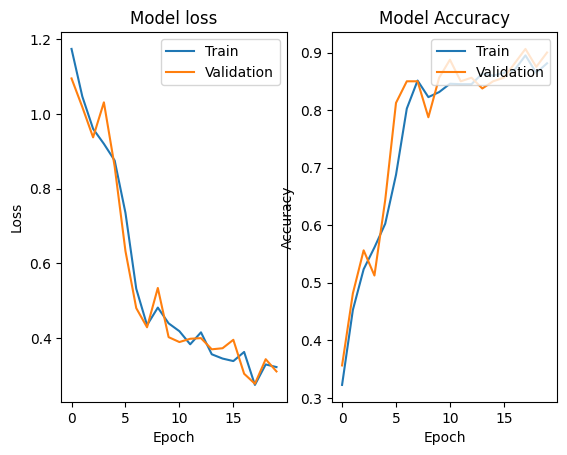

In [15]:
plt.subplot(1, 2, 1)
plt.plot(historyModel.history['loss'])
plt.plot(historyModel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(historyModel.history['accuracy'])
plt.plot(historyModel.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 152ms/step
Paper


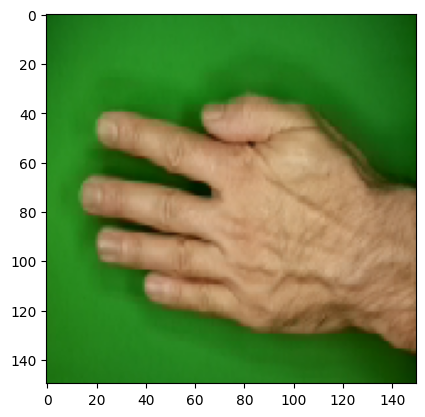

In [16]:
uploaded = os.path.join(paper_dir,'0Og76sl5CJhbxWWx.png')
img = tf.keras.utils.load_img(uploaded, target_size = (150, 150))
 
imgplot = plt.imshow(img)
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)  
if classes[0][0] == 1:
  print('Paper')
elif classes[0][1] == 1:
  print('Rock')
else:
  print('Scissors')

## Evaluation

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_data, steps=val_data.n)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

 14/437 [..............................] - ETA: 3:02 - loss: 0.3020 - accuracy: 0.8970

437/437 [==============================] - 6s 14ms/step - loss: 0.3020 - accuracy: 0.8970
Test Loss: 0.30196982622146606
Test Accuracy: 0.8970251679420471


## Rock, Paper, Scissor Game

In [18]:
def game(hand_1, hand_2):
  img1 = tf.keras.utils.load_img(hand_1, target_size = (150, 150))
  
  #imgplot1 = plt.imshow(img1)
  x1 = tf.keras.utils.img_to_array(img1)
  x1 = np.expand_dims(x1, axis=0)
  images1 = np.vstack([x1])

  classes1 = model.predict(images1, batch_size=10)  

  img2 = tf.keras.utils.load_img(hand_2, target_size = (150, 150))
  
  #imgplot2 = plt.imshow(img2)
  x2 = tf.keras.utils.img_to_array(img2)
  x2 = np.expand_dims(x2, axis=0)
  images2 = np.vstack([x2])

  classes2 = model.predict(images2, batch_size=10)  

  plt.subplot(1, 2, 1)  # Create a subplot for img1
  plt.imshow(img1)
  plt.title('Image 1')
  plt.xlabel(f'Class: {np.argmax(classes1)}')

  plt.subplot(1, 2, 2)  # Create a subplot for img2
  plt.imshow(img2)
  plt.title('Image 2')
  plt.xlabel(f'Class: {np.argmax(classes2)}')

  plt.tight_layout()  # Adjust spacing between subplots
  plt.show()

  if classes1[0][0] == 1:
    h1 = 'paper'
  elif classes1[0][1] == 1:
    h1 = 'rock'
  else:
    h1 = 'scissors'


  if classes2[0][0] == 1:
    h2 = 'paper'
  elif classes2[0][1] == 1:
    h2 = 'rock'
  else:
    h2 = 'scissors'


  print("h1: ", h1)
  print("h2: ", h2)


  if h1 == 'paper':
    if h2 == 'rock':
      print("hand 1 won")
    elif h2 == 'paper':
      print("draw")
    else:
      print("hand 2 won")

  if h1 == 'rock':
    if h2 == 'paper':
      print("hand 2 won")
    elif h2 == 'rock':
      print("draw")
    else:
      print("hand 1 won")

  if h1 == 'scissors':
    if h2 == 'rock':
      print("hand 2 won")
    elif h2 == 'scissors':
      print("draw")
    else:
      print("hand 1 won")

1/1 [==============================] - 0s 34ms/step


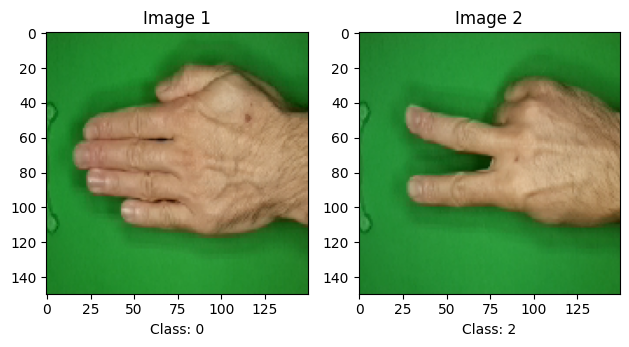

h1:  paper
h2:  scissors
hand 2 won


In [19]:
hand_1 = '/content/rps-cv-images/paper/0a3UtNzl5Ll3sq8K.png'
hand_2 = '/content/rps-cv-images/scissors/2M8LvUBGMOH1bsaz.png'

game(hand_1, hand_2)